In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.colab import drive
import warnings
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from scipy import stats
import pickle
from kmodes.kmodes import KModes
from imblearn.over_sampling import SMOTENC
from collections import Counter
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import accuracy_score, recall_score, f1_score,precision_score, roc_auc_score
import xgboost as xgb
from catboost import CatBoostClassifier
import joblib

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/eitesalat/Etisalat_UseCase.zip (Unzipped Files)/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [ ]:
data = df.copy()

**exploring the data**


In [ ]:
data.head()

,customerID,gender,Senior_Citizen,Is_Married,Dependents,tenure,Phone_Service,Dual,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customerID         7043 non-null   object 
 1   gender             7043 non-null   object 
 2   Senior_Citizen     7043 non-null   int64  
 3   Is_Married         7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   tenure             7043 non-null   int64  
 6   Phone_Service      7043 non-null   object 
 7   Dual               7043 non-null   object 
 8   Internet_Service   7043 non-null   object 
 9   Online_Security    7043 non-null   object 
 10  Online_Backup      7043 non-null   object 
 11  Device_Protection  7043 non-null   object 
 12  Tech_Support       7043 non-null   object 
 13  Streaming_TV       7043 non-null   object 
 14  Streaming_Movies   7043 non-null   object 
 15  Contract           7043 non-null   object 
 16  Paperless_Billing  7043 

all features are categorical features
except 'tenure' and 'monthly charges',and total charges

In [ ]:
data['Total_Charges'] = pd.to_numeric(data['Total_Charges'], errors='coerce') #coerce to set invalid parsing with nan

In [ ]:
duplicates = data.duplicated().sum()
print(duplicates)

0


In [ ]:
data['Total_Charges'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 7043 entries, 0 to 7042
Series name: Total_Charges
Non-Null Count  Dtype  
--------------  -----  
7032 non-null   float64
dtypes: float64(1)
memory usage: 55.1 KB


although the data seemed to be complete but total charges had Null values
after using to_numeric

In [ ]:
data.describe()

,Senior_Citizen,tenure,Monthly_Charges,Total_Charges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [ ]:
data.Churn.value_counts()

,count
Churn,
No,5174
Yes,1869


churn is imbalanced

In [ ]:
data['Senior_Citizen '] = data['Senior_Citizen '].map({1:'Yes',0:'No'}) # make senior_citzen a string

In [ ]:
data.drop('customerID', axis=1, inplace=True) # the id is not needed

will use a random forrest as a base model since it doesn't require advanced cleaning or feature engineering and random forrest is a good model for data with many categorical features

In [ ]:
target = 'Churn'
train_ds_pd, valid_ds_pd = train_test_split(data, test_size=0.30, random_state=42, stratify=data[target])
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=target, task = tfdf.keras.Task.CLASSIFICATION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=target, task = tfdf.keras.Task.CLASSIFICATION)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
rf.compile(metrics=["accuracy"])

Use /tmp/tmpxj7bs35f as temporary training directory


In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:01.803921. Found 4930 examples.
Training model...
Model trained in 0:00:10.190361
Compiling model...
Model compiled.


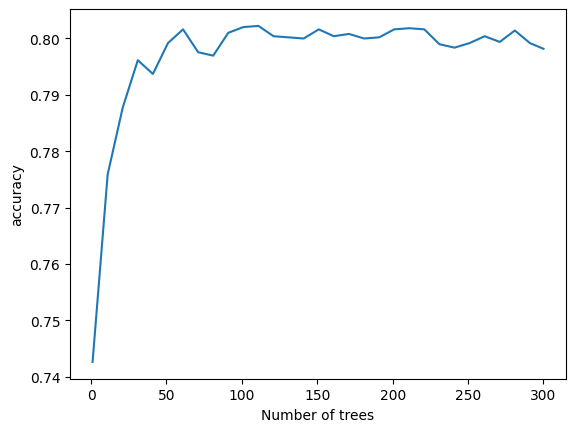

In [ ]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("accuracy")
plt.show()

In [ ]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=4930, accuracy=0.7981744421906694, loss=0.5329083452876808, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [ ]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

3/3 [==============================] - 1s 52ms/step - loss: 0.0000e+00 - accuracy: 0.7903
loss: 0.0000
accuracy: 0.7903


base val accuracy is 79%

In [ ]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [ ]:
inspector.variable_importances()["NUM_AS_ROOT"]

[("Contract" (4; #0), 87.0),
 ("Online_Security" (4; #8), 60.0),
 ("Tech_Support" (4; #15), 51.0),
 ("tenure" (1; #19), 29.0),
 ("Payment_Method" (4; #10), 25.0),
 ("Internet_Service" (4; #4), 21.0),
 ("Device_Protection" (4; #2), 8.0),
 ("Online_Backup" (4; #7), 8.0),
 ("Streaming_Movies" (4; #13), 4.0),
 ("Monthly_Charges" (1; #6), 3.0),
 ("Streaming_TV" (4; #14), 3.0),
 ("Total_Charges" (1; #16), 1.0)]

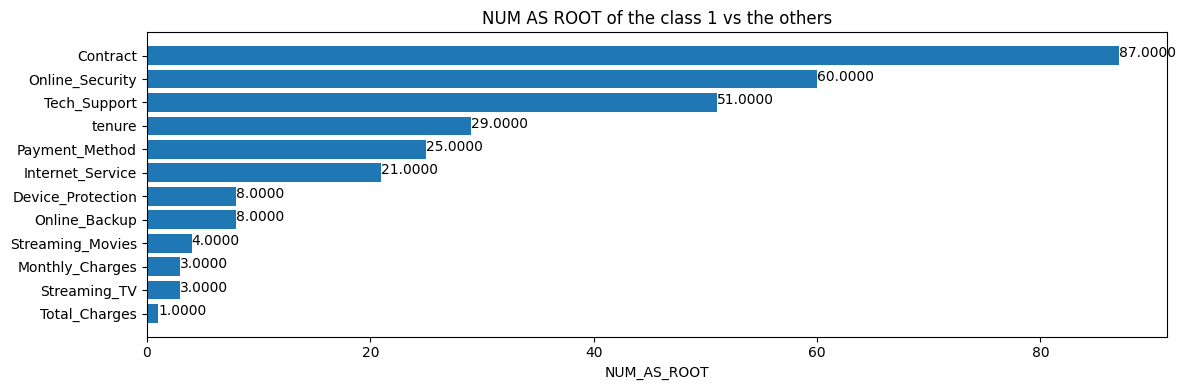

In [ ]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

this is important features for the random forrest, these features will help us in the feature engineering

**visualizing the dataset**

will make 2 lists to save the columns of categorical and numerical
features

In [ ]:
numerical_features = ['tenure','Monthly_Charges','Total_Charges']
categorical_features = data.columns.difference(numerical_features)

In [ ]:
target = 'Churn'
df_numerical= data[numerical_features] # a dataframe for numeric values for visualization
df_numerical.columns = numerical_features
df_numerical[target] = data[target] # will add churn to df_numerical for visualizations

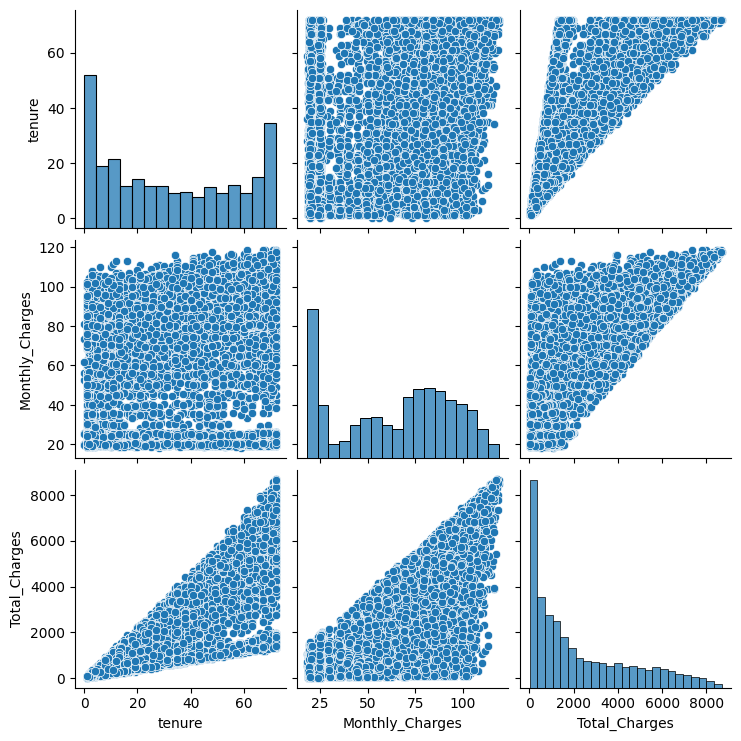

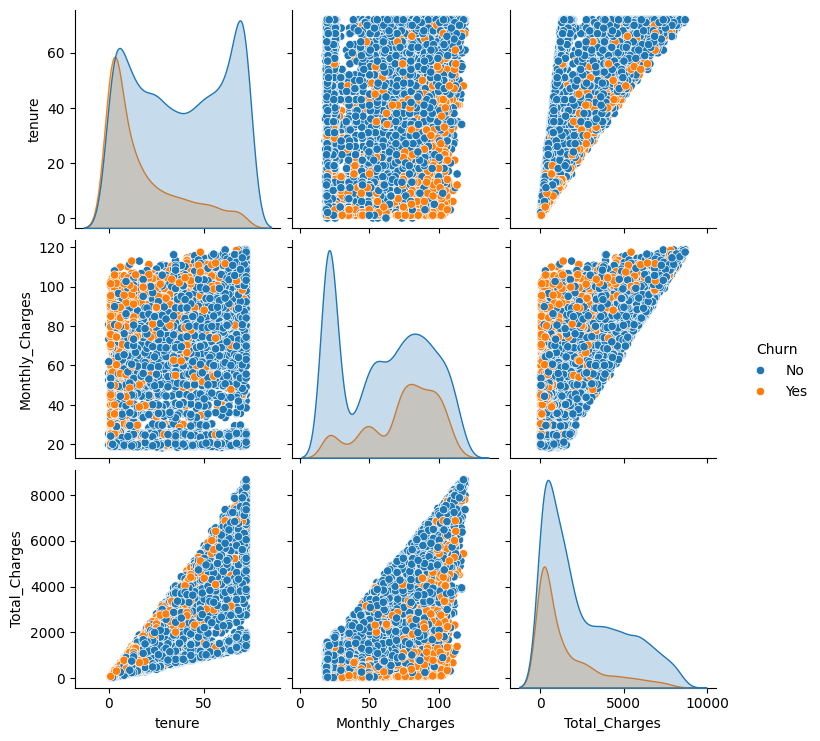

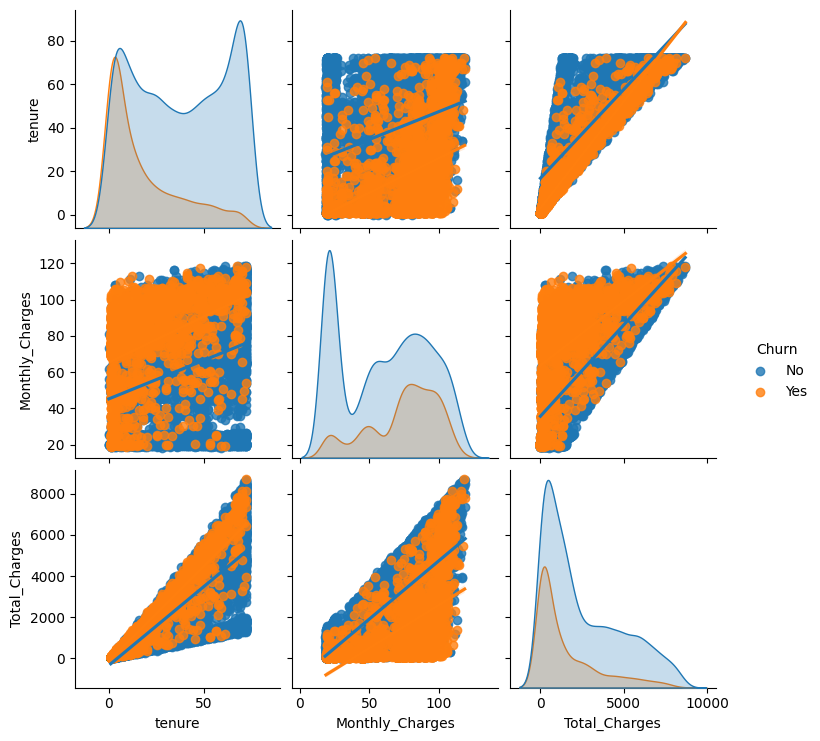

In [ ]:
# Basic correlogram
sns.pairplot(df_numerical, kind="scatter")

# Annotate classes with in different colours
sns.pairplot(df_numerical, kind="scatter", hue=target)

# Use regression instead of scatter
sns.pairplot(df_numerical, kind="reg", hue=target)

1- monthly charges and tenure show relationship with total charges

2- total charges is positively skewed

3- monthly charges and tenure have bimodal distributions which suggest clusters in the data

4-monthl charges and tenure show some pattern in churn = Yes, but total chaos at churn = No

visuaizig categorical features

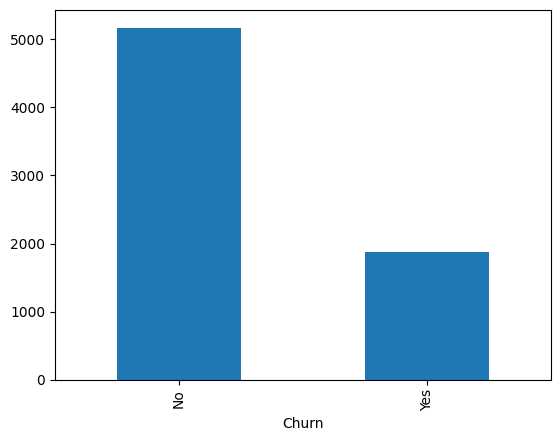

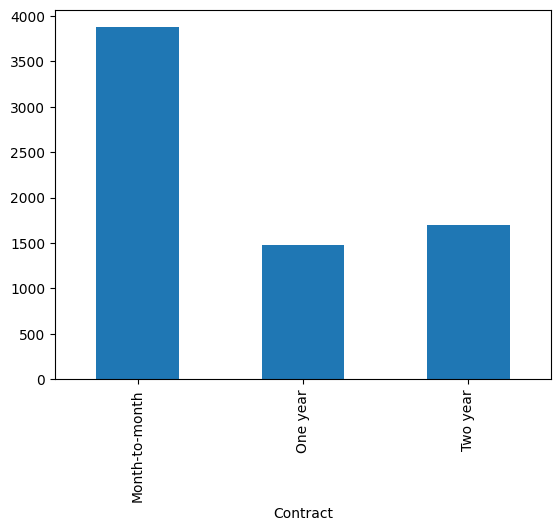

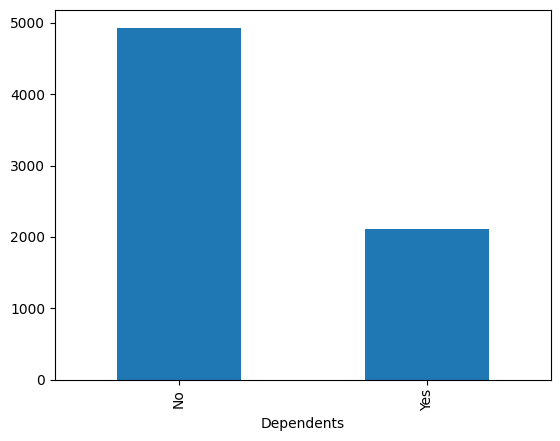

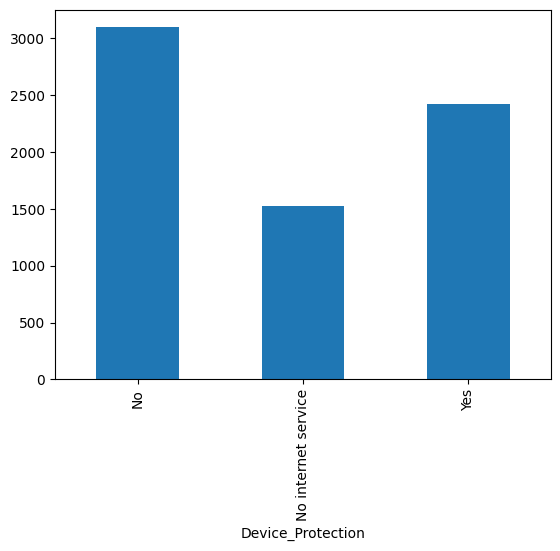

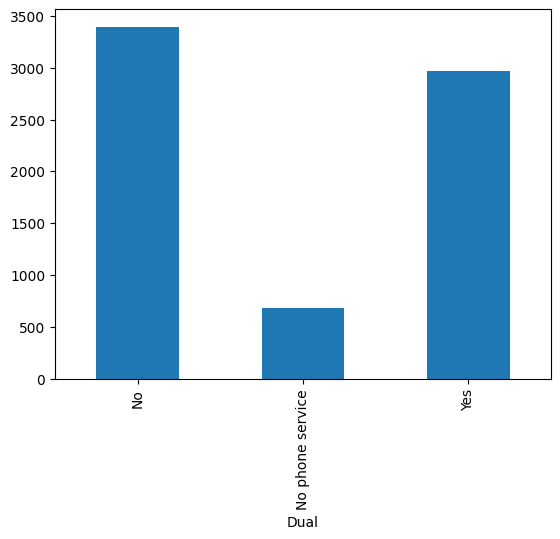

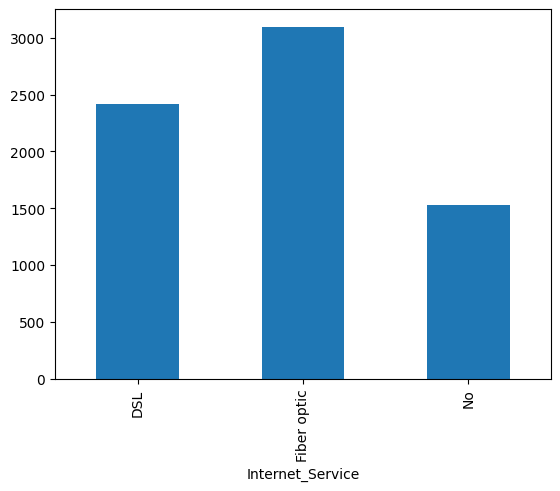

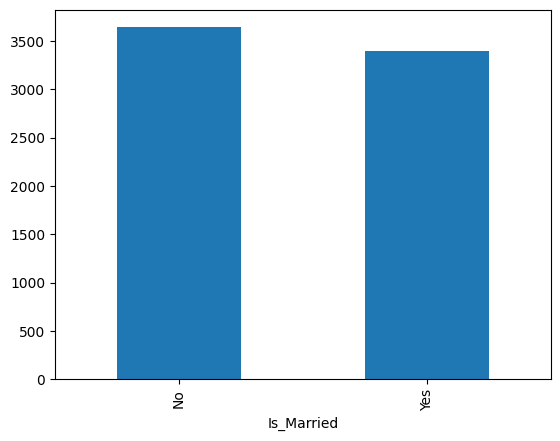

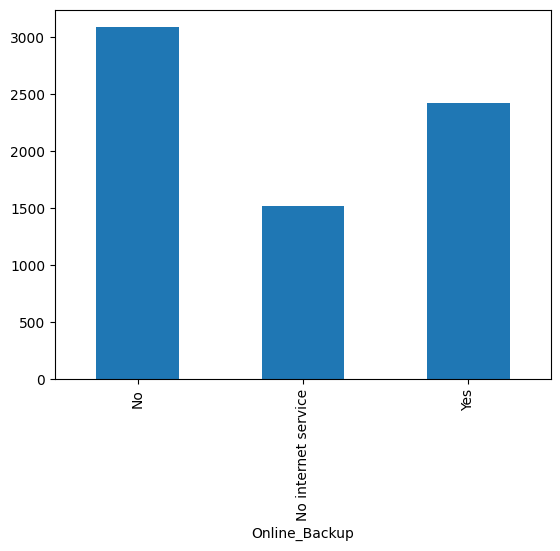

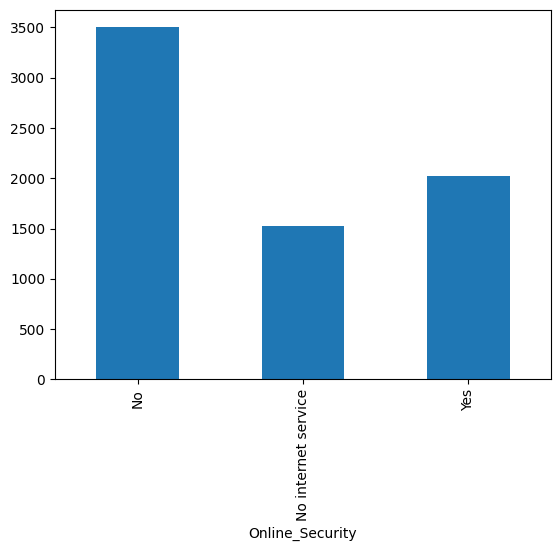

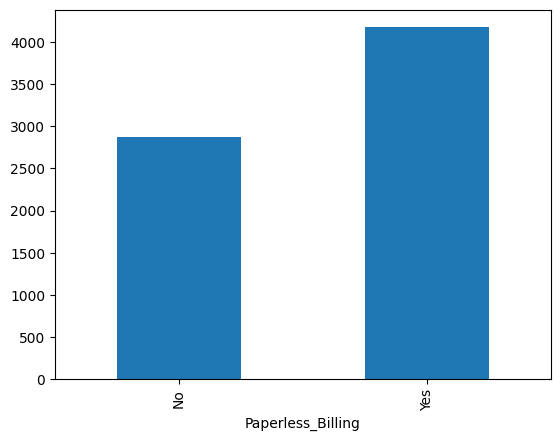

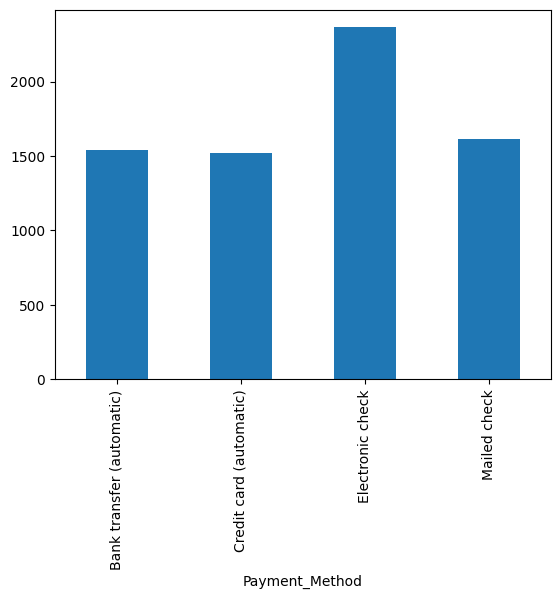

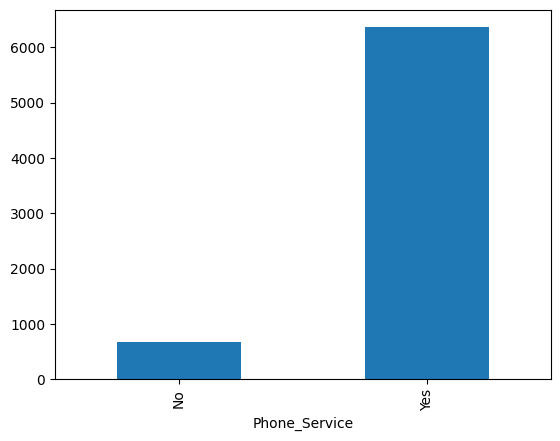

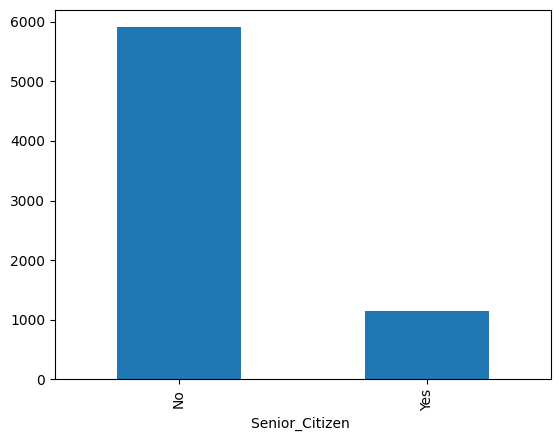

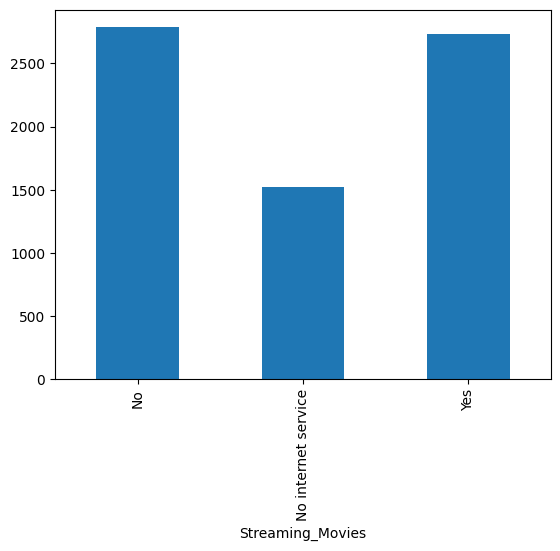

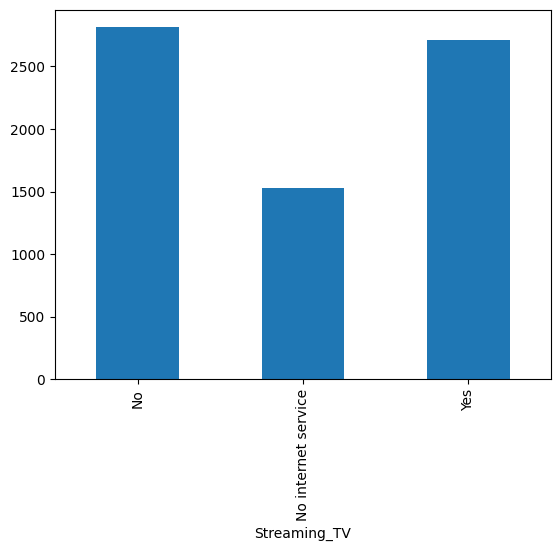

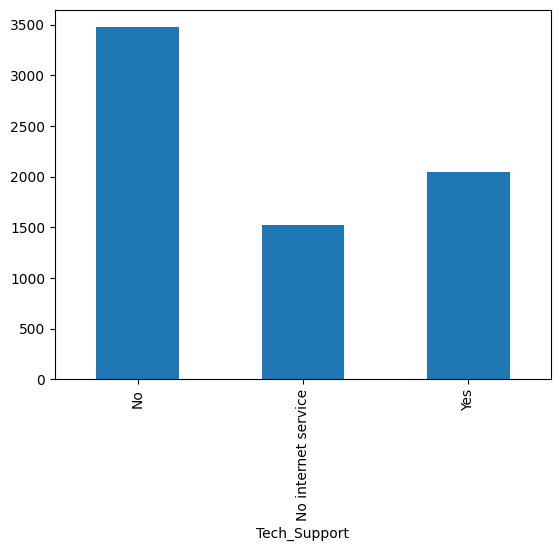

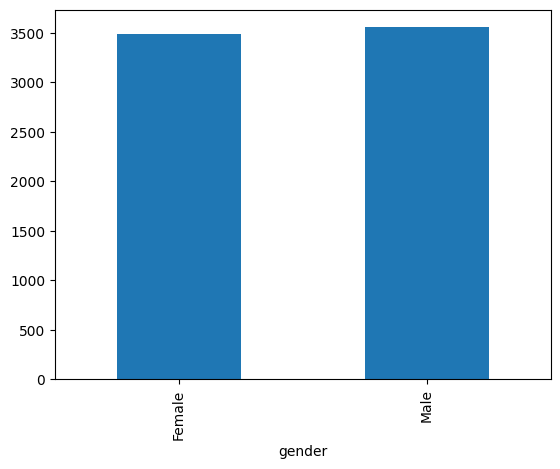

In [ ]:
for i in categorical_features:
  data.groupby(i).size().plot(kind='bar')
  plt.show()

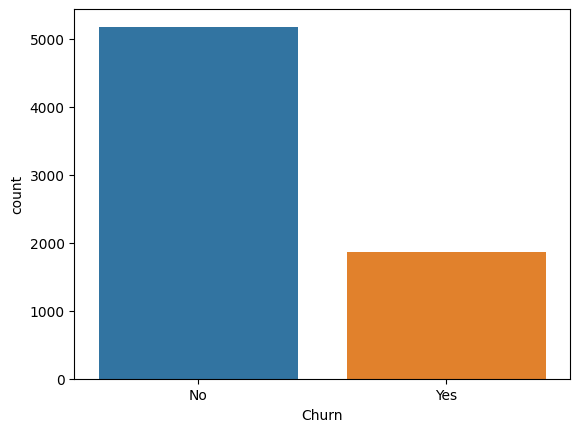

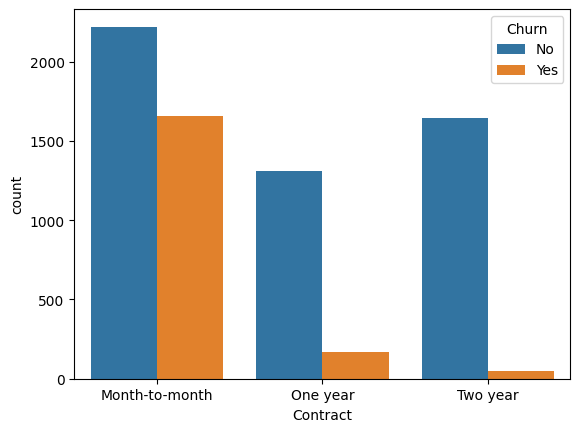

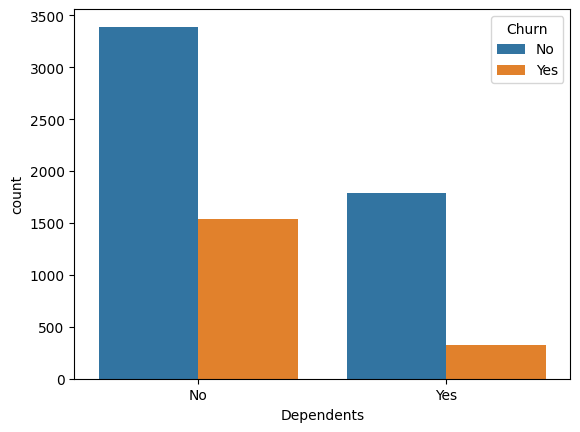

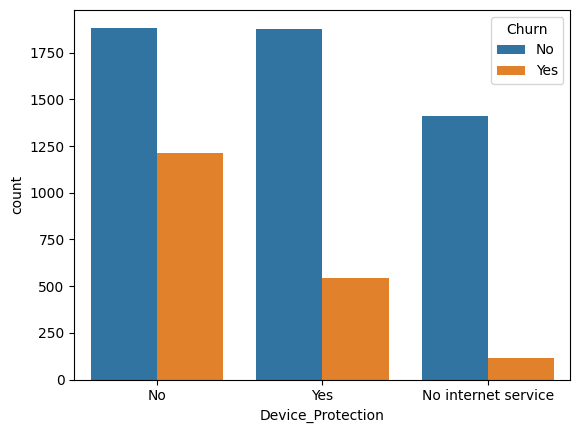

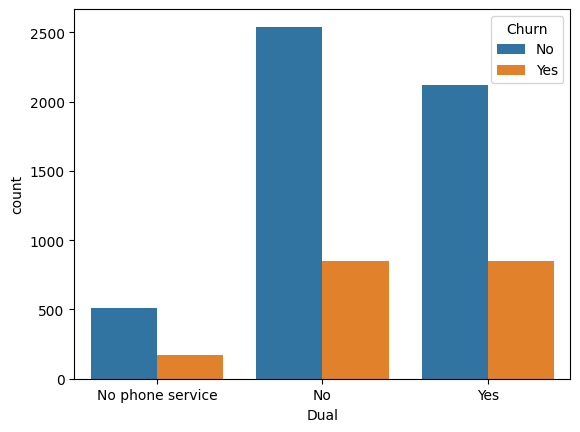

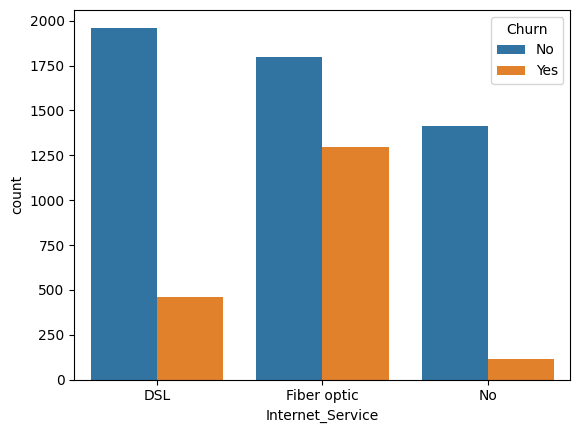

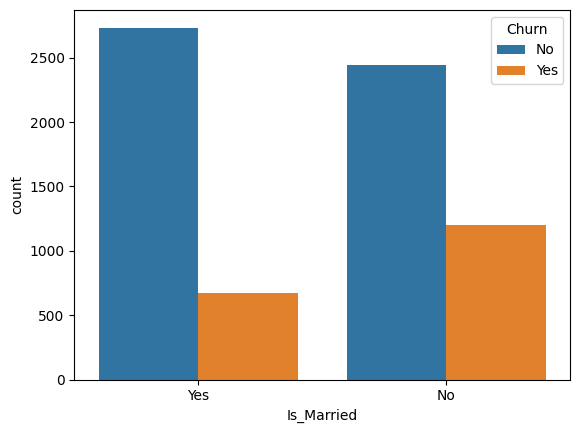

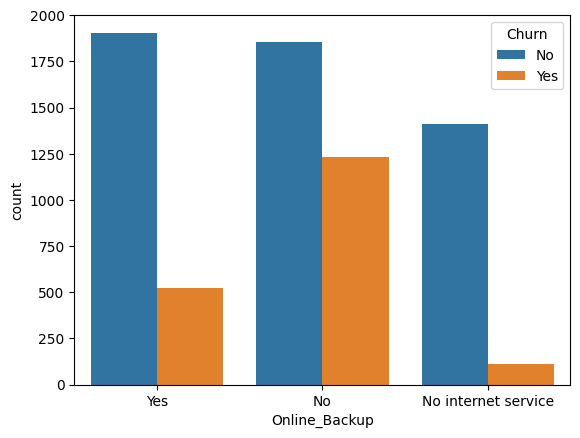

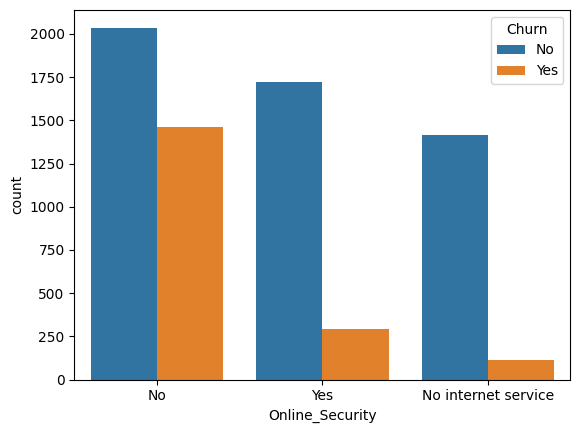

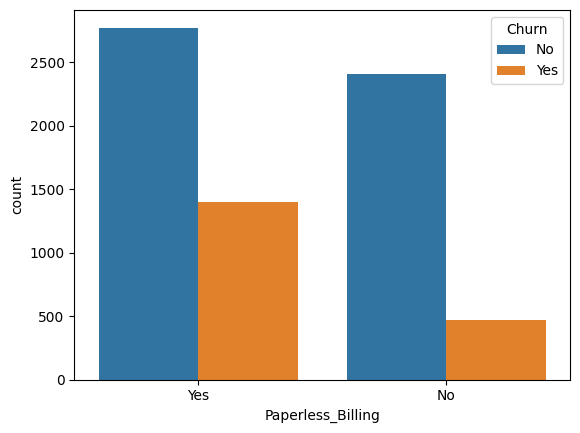

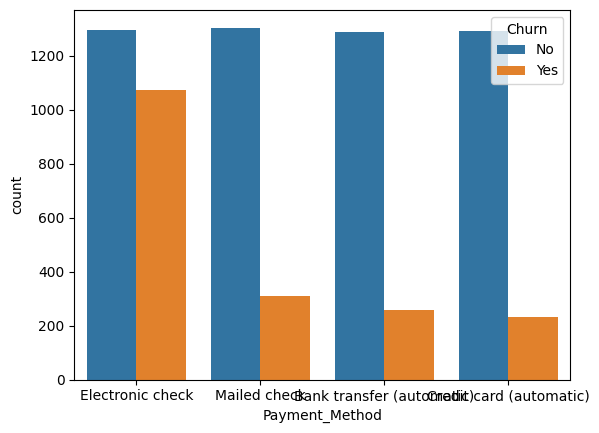

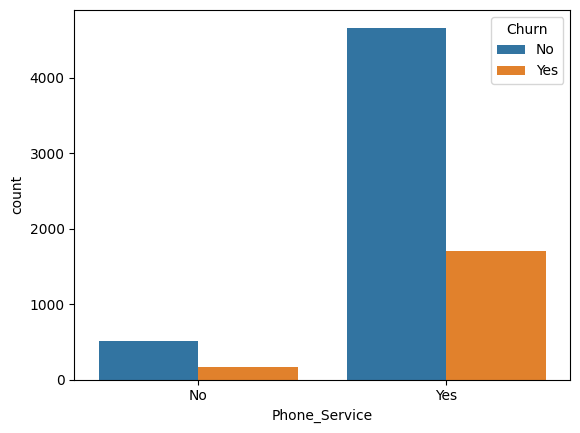

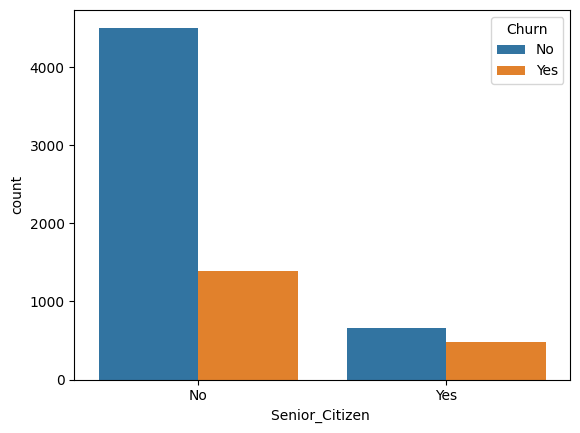

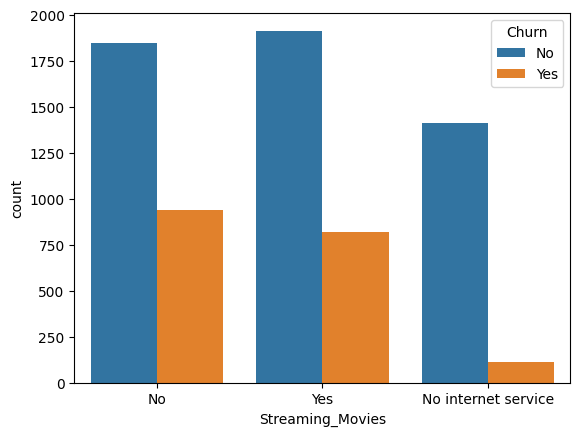

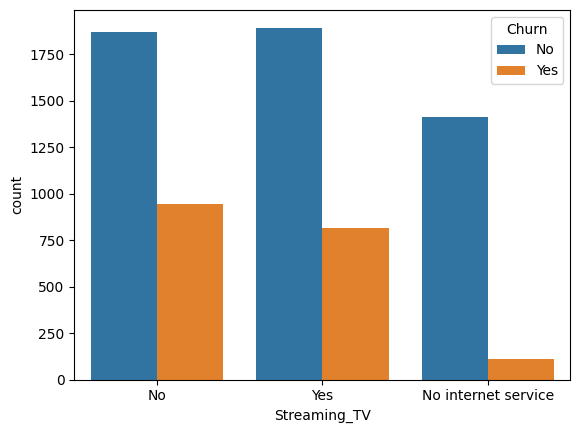

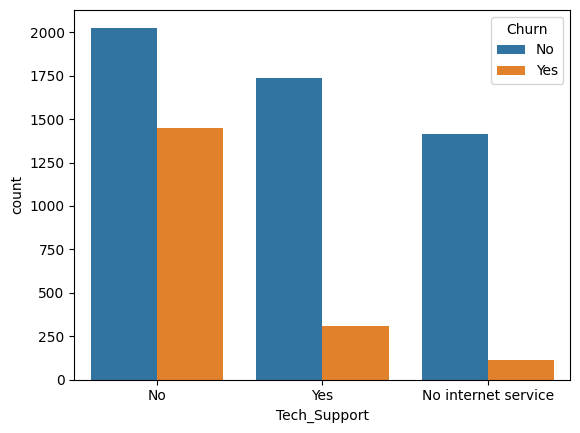

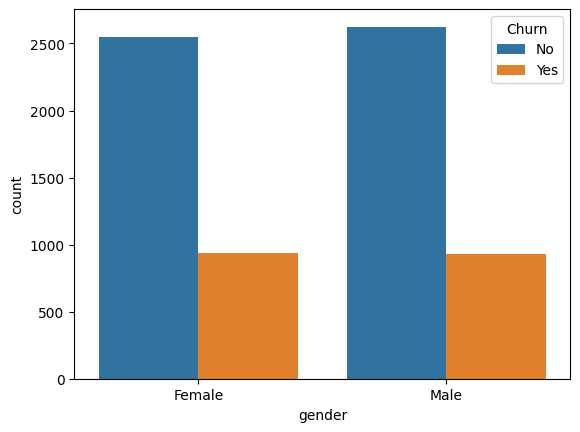

In [ ]:
for i in categorical_features:
  sns.countplot(data=data, x=i,hue= target)
  plt.show()

1- in contract feature month to month show much more churn = yes than other Values in conract

2- in device protection feature, No has much higher yes to no ratio than other values

3- in internet service feature, fiber optic has much higher yes to no ratio than other values

4- no online backup and no online security has very high yes ratio

5- no internet services is very mostly churn = No

6- electronic check in payment method is very different than other values as its yes to no ratio is much higher

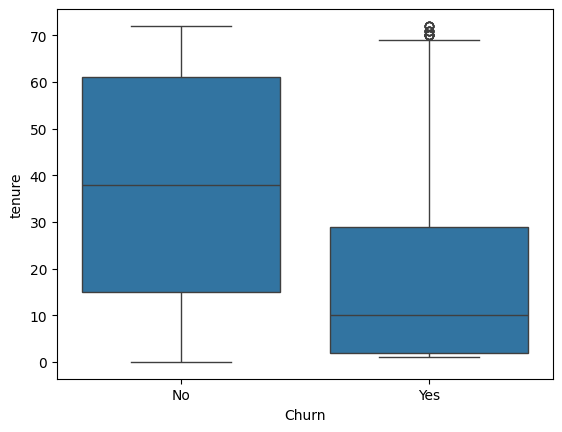

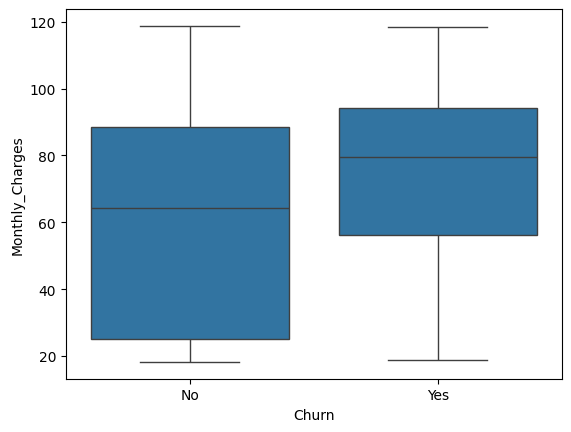

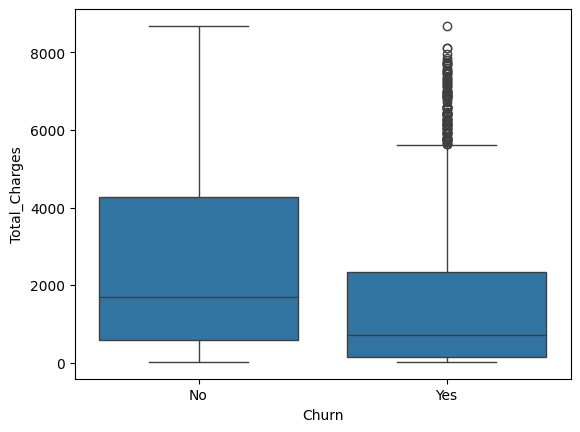

In [ ]:
for i in numerical_features:
  sns.boxplot(data=data, x=target, y=i)
  plt.show()

Numeric features distributions is highly affected by churn, total charges
has many outliers

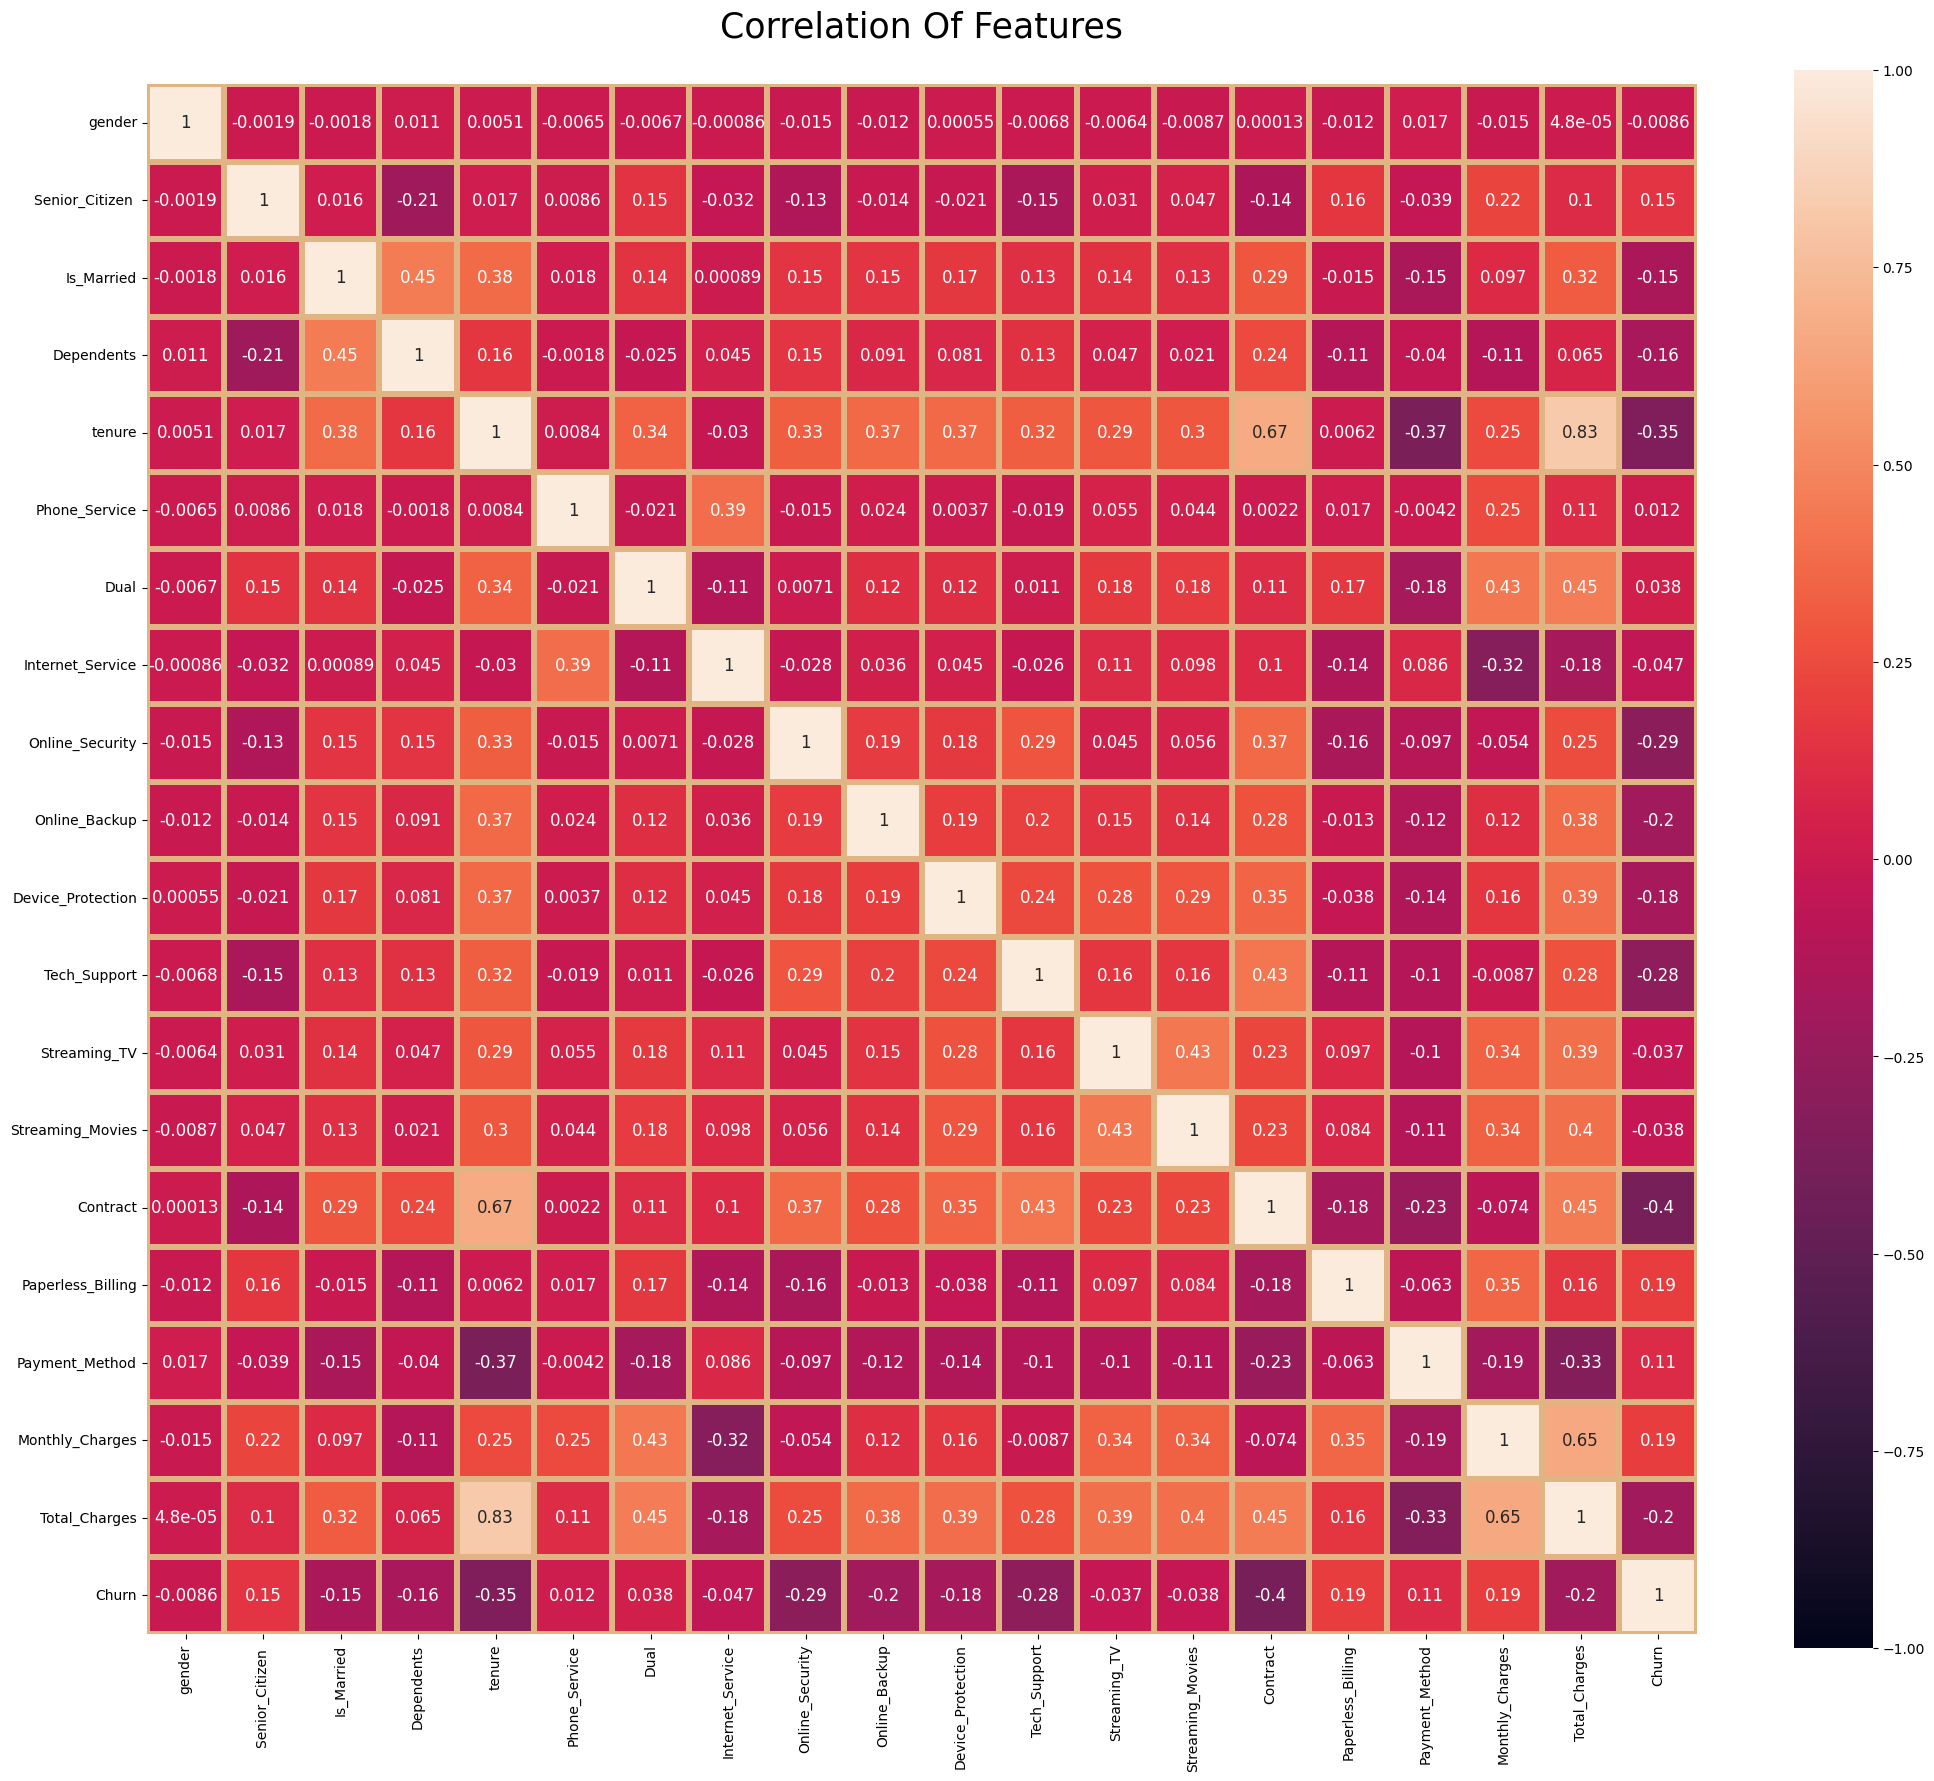

In [ ]:
df_corr = data.copy()

catcol = [col for col in df_corr.columns if df_corr[col].dtype == "object"]
le = LabelEncoder()
for col in catcol:
        df_corr[col] = le.fit_transform(df_corr[col])


plt.subplots(figsize =(25, 25))

sns.heatmap(df_corr.corr(), square=True, cbar_kws=dict(shrink =.82),
            annot=True, vmin=-1, vmax=1, linewidths=3,linecolor='#e0b583',annot_kws=dict(fontsize =12))
plt.title("Correlation Of Features\n", fontsize=25)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

there are many insights from the heatmap:

1- Total Charges(the only feature having missing values) have very high correlation with tenure and monthly charges -- logical

2- Online_Security, Online_Backup, Device_Protection and Tech_Support seem to have similar correlation with most features. Dual share similar correlation with the features but not exactly the same pattern

**preprocessing and feature engineering**

In [ ]:
data.head()

,gender,Senior_Citizen,Is_Married,Dependents,tenure,Phone_Service,Dual,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Phone service seem like redundant data, it is repeted in dual .. let's remove it

In [ ]:
data.drop('Phone_Service', axis=1, inplace=True)

let's find wether we will delete the rows with nan values or not

In [ ]:
#filt = data['Total_Charges'].isna()
#data.loc[filt,'Total_Charges'] = data.loc[filt,'Monthly_Charges']

In [ ]:
TCNan_filt = data['Total_Charges'].isna()
data[TCNan_filt]

,gender,Senior_Citizen,Is_Married,Dependents,tenure,Dual,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn
488,Female,No,Yes,Yes,0,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,No,No,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,No,Yes,Yes,0,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,No,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,No,Yes,Yes,0,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,No,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,No,Yes,Yes,0,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,No,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,No,Yes,Yes,0,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,No,Yes,Yes,0,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


in Total_Charges = Nan, all tenure = 0, all

churn = No, all Dependents = Yes and all Senior_Citizens = No

nan rows seem to have a pattern, we shouldn't delete the nan rows

since Total charges has very high correlation with tenure and with Monthly_Charges we will start looking into that

from the graphs that visualize the relationship between numerical values above, tenure and Monthly_charges seem to have some sort of linear relationship wih Total_charges

from business understanding, Total charges should be Monthly_Charges * tenure if the customer didn't change his contract or plan

In [ ]:
data['tenure_MonthlyCharges'] = data['Monthly_Charges'] * data['tenure']

<Axes: xlabel='Total_Charges', ylabel='tenure_MonthlyCharges'>

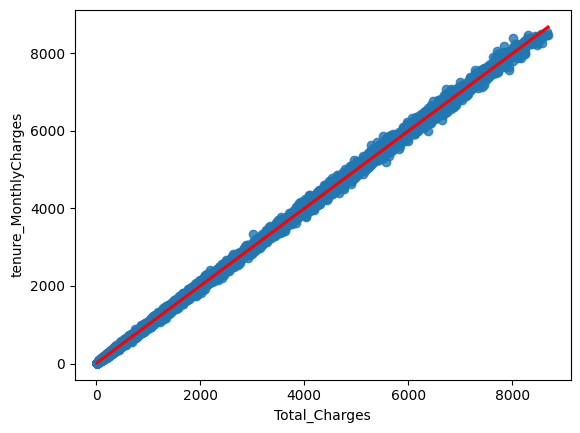

In [ ]:
sns.regplot(x='Total_Charges', y='tenure_MonthlyCharges', data=data[~TCNan_filt], line_kws={'color':'red'})

In [ ]:
data.loc[~TCNan_filt,['Total_Charges','tenure_MonthlyCharges']].corr()

,Total_Charges,tenure_MonthlyCharges
Total_Charges,1.00000,0.99956
tenure_MonthlyCharges,0.99956,1.00000


Total Charges seem like a redundant feature, lets drop it

In [ ]:
data.drop(['Total_Charges','tenure_MonthlyCharges'], axis=1, inplace=True)

In [ ]:
for i in data.columns:
  print(i + '    ' + str(data[i].unique()))

gender    ['Female' 'Male']
Senior_Citizen     ['No' 'Yes']
Is_Married    ['Yes' 'No']
Dependents    ['No' 'Yes']
tenure    [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Dual    ['No phone service' 'No' 'Yes']
Internet_Service    ['DSL' 'Fiber optic' 'No']
Online_Security    ['No' 'Yes' 'No internet service']
Online_Backup    ['Yes' 'No' 'No internet service']
Device_Protection    ['No' 'Yes' 'No internet service']
Tech_Support    ['No' 'Yes' 'No internet service']
Streaming_TV    ['No' 'Yes' 'No internet service']
Streaming_Movies    ['No' 'Yes' 'No internet service']
Contract    ['Month-to-month' 'One year' 'Two year']
Paperless_Billing    ['Yes' 'No']
Payment_Method    ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Monthly_Charges    [29.85 56.95 53.85 ... 63.1  44

now many features contain redundunt info, this increase the dimensionality of the data making it harder for the model to classify it

I will combine some features together based on their logical relationship to reduce dimensionality

In [ ]:
data_t = data.copy()

In [ ]:
data = data_t.copy()

In [ ]:
data['O_B_S_Dp'] = data['Online_Security'] + "_" + data['Online_Backup']+ "_" + data['Device_Protection']
data.drop(['Online_Security','Online_Backup','Device_Protection'], axis=1, inplace=True)
data['O_B_S_Dp'].unique()

array(['No_Yes_No', 'Yes_No_Yes', 'Yes_Yes_No', 'No_No_No', 'No_No_Yes',
       'Yes_No_No',
       'No internet service_No internet service_No internet service',
       'No_Yes_Yes', 'Yes_Yes_Yes'], dtype=object)

here i combined the features based on security

here every feature had 3 unique values, the total of 3 * 3 * 3 should be 27 unique values, but we got 9. since no internet service is a common element and always occure at the same time in the 3 features we got 2 * 2 * 2 + 1 = 9  

In [ ]:
data['S_TV_M'] = data['Streaming_TV'] + "_" + data['Streaming_Movies']
data.drop(['Streaming_TV','Streaming_Movies'], axis=1, inplace=True)

In [ ]:
data['IS_TS'] = data['Internet_Service'] + "_" + data['Tech_Support']
data.drop(['Internet_Service','Tech_Support'], axis=1, inplace=True)

the bimodal distributions of Tenure and Monthly Charges from the graphs of numerical features and the insights from the heatmap suggest clusters in the data.

lets explore that

lets try adding a cluster feature of the features that showed similar pattern in the heatmap

features that showed a pattern are Online_Security, Online_Backup, Device_Protection and Tech_Support. all these are personal choices. I will add other features that show the character of the customer to cluster characters of customers

I experimented with the features used in clustering

In [ ]:
columns = ['S_TV_M','IS_TS','O_B_S_Dp','Contract','Payment_Method']
categorical_indices = [data.columns.get_loc(col) for col in columns]

In [ ]:
data_c = data.copy()

In [ ]:
data = data_c.copy()

In [ ]:
for col in columns:
    data[col] = data[col].astype('category').cat.codes

kmodes = KModes(n_clusters=5, init='Huang', n_init=15, verbose=1)
kmodes.fit(data)
print(kmodes.cluster_centroids_)
print(kmodes.labels_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 2225, cost: 42090.0
Run 1, iteration: 2/100, moves: 489, cost: 41849.0
Run 1, iteration: 3/100, moves: 276, cost: 41731.0
Run 1, iteration: 4/100, moves: 34, cost: 41731.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 2646, cost: 41472.0
Run 2, iteration: 2/100, moves: 609, cost: 41472.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2173, cost: 42018.0
Run 3, iteration: 2/100, moves: 113, cost: 42018.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 2928, cost: 41162.0
Run 4, iteration: 2/100, moves: 1350, cost: 40685.0
Run 4, iteration: 3/100, moves: 673, cost: 40478.0
Run 4, iteration: 4/100, moves: 57, cost: 40478.0
Init: initializing centroids
Init: initializing clusters
Starting

In [ ]:
data = data_c.copy()
data['Cluster'] = kmodes.labels_
data['Cluster'] = data['Cluster'].astype(str)

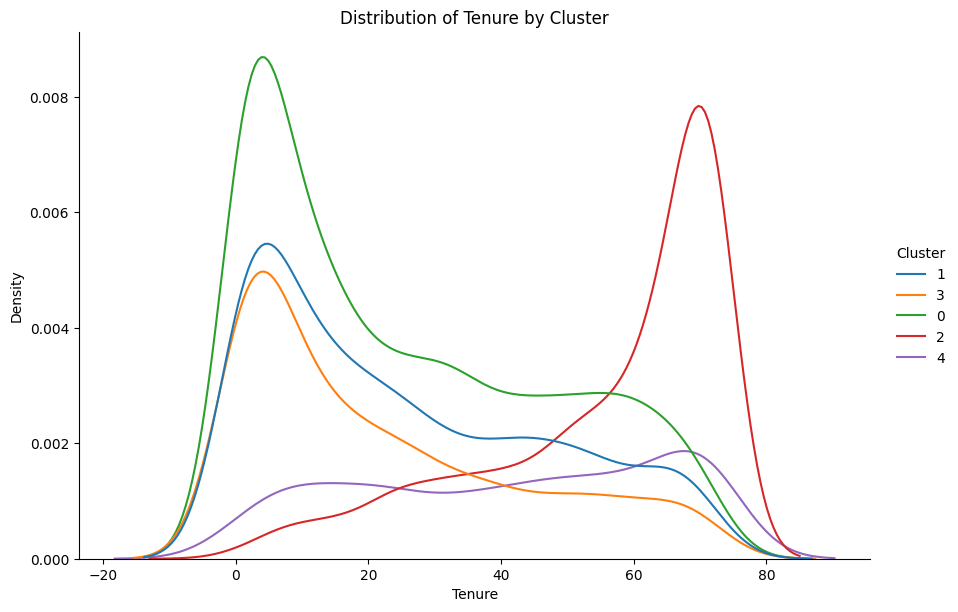

In [ ]:
# Example: Assuming 'data' is your dataframe and contains 'tenure' and 'Cluster' columns
sns.displot(data=data, x='tenure', hue='Cluster', kind='kde', height=6, aspect=1.5)

# Optional: Customize the plot
plt.title('Distribution of Tenure by Cluster')
plt.xlabel('Tenure')
plt.ylabel('Density')

# Show the plot
plt.show()

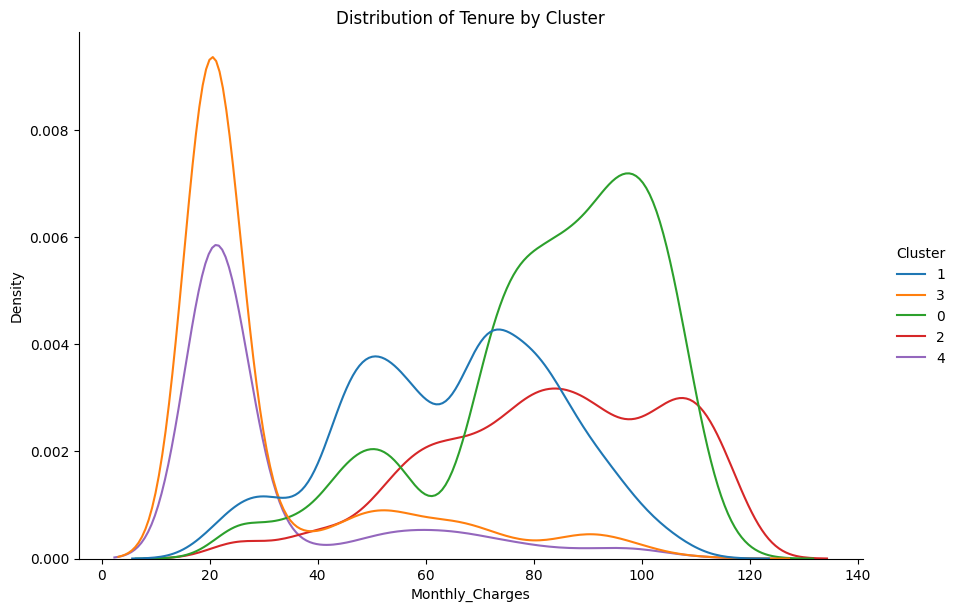

In [ ]:
# Example: Assuming 'data' is your dataframe and contains 'tenure' and 'Cluster' columns
sns.displot(data=data, x='Monthly_Charges', hue='Cluster', kind='kde', height=6, aspect=1.5)

# Optional: Customize the plot
plt.title('Distribution of Tenure by Cluster')
plt.xlabel('Monthly_Charges')
plt.ylabel('Density')

# Show the plot
plt.show()

the data did contain clusters, and with the data custered all the distributions now make sense

In [ ]:
data_temp = data.copy()

In [ ]:
data = data_temp.copy()

lets remove the features used in clusering

In [ ]:
for i in columns:
  if i not in ['Contract','Payment_Method','Internet_Service']:
    data.drop(i, axis=1, inplace=True)

now let's scale numerial data and encode categorical data

In [ ]:
numerical_features = ['tenure','Monthly_Charges']
categorical_features = data.columns.difference(numerical_features).difference(['Churn'])

In [ ]:
def preprocess_numerical(df,numerical_features):
    for i in numerical_features:
      #df[i] = np.sqrt(df[i])
      sc = MinMaxScaler()
      df[i] = sc.fit_transform(df[[i]])
    return df

def preprocess_categorical(df,categorical_features):
    df=pd.get_dummies(df,columns=categorical_features)
    return df

**finally, machine learning**


will start testing the data on Random Forrest

random forrest doesn't need one hot encoding,so will only use preprocess numerical

In [ ]:
data_rf = preprocess_numerical(data,numerical_features)

In [ ]:
target = 'Churn'
train_ds_pd, valid_ds_pd = train_test_split(data_rf, test_size=0.30, random_state=42, stratify=data[target])
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=target, task = tfdf.keras.Task.CLASSIFICATION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=target, task = tfdf.keras.Task.CLASSIFICATION)

In [ ]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
rf.compile(metrics=["accuracy"])

Use /tmp/tmp9qzdru_7 as temporary training directory


In [ ]:
rf.fit(x=train_ds)

Reading training dataset...


Training dataset read in 0:00:00.425052. Found 4930 examples.
Training model...
Model trained in 0:00:02.548095
Compiling model...
Model compiled.


In [ ]:
y_pred_prob = rf.predict(valid_ds)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)


y_true = valid_ds_pd[target].map({'No': 0, 'Yes': 1}).values  # Assuming target column is 'Churn'

rf_accuracy = accuracy_score(y_true, y_pred_binary)
rf_precision = precision_score(y_true, y_pred_binary)
rf_recall = recall_score(y_true, y_pred_binary)
rf_f1 = f1_score(y_true, y_pred_binary)
rf_auc = roc_auc_score(y_true_rf, y_pred_prob_rf)

# Print the metrics
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"Random Forest AUC: {rf_auc:.4f}")

3/3 [==============================] - 0s 28ms/step
Accuracy: 0.8590
Precision: 0.7604
Recall: 0.6845
F1-Score: 0.7205
Random Forest AUC: 0.8965


lets try neural networks

In [ ]:
data_nn = preprocess_numerical(data,numerical_features)
data_nn = preprocess_categorical(data_nn,categorical_features)
Y = data_nn['Churn']
X = data_nn.drop('Churn', axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42,stratify=Y)

In [ ]:
x_train.shape, x_test.shape

((4930, 27), (2113, 27))

In [ ]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [ ]:
y_train.shape, y_test.shape

((4930,), (2113,))

In [ ]:
input_size = 27

lets's try to know the best hyperparameters for the nn

In [ ]:
def create_nn(input_size, hidden_layers=[128, 32], dropout_rate=0.5, learning_rate=0.001):


    model = Sequential()

    model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_size))

    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))


    optimizer = Adam(learning_rate=learning_rate)


    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
nn = create_nn(input_size=input_size, hidden_layers=[64, 16], dropout_rate=0.2, learning_rate=0.0005)

nn.summary()

Model: "sequential_149"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_445 (Dense)                    │ (None, 64)                  │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_446 (Dense)                    │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_274 (Dropout)                │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_447 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,849 (11.13 KB)

 Trainable params: 2,849 (11.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
nn.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=16)

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7013 - loss: 0.5570 - val_accuracy: 0.8367 - val_loss: 0.3954
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8279 - loss: 0.3980 - val_accuracy: 0.8479 - val_loss: 0.3699
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8470 - loss: 0.3661 - val_accuracy: 0.8448 - val_loss: 0.3597
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8559 - loss: 0.3498 - val_accuracy: 0.8529 - val_loss: 0.3546
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8645 - loss: 0.3431 - val_accuracy: 0.8509 - val_loss: 0.3514
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8617 - loss: 0.3415 - val_accuracy: 0.8448 - val_loss: 0.3508
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8667 - loss: 0.3231 - val_accuracy: 0.8479 - val_loss: 0.3499
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8621 - loss: 0.3251 - val_accuracy: 0.

In [ ]:
y_pred_prob = nn.predict(x_test)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)


y_true = y_test


nn_accuracy = accuracy_score(y_true, y_pred_binary)
nn_recall = recall_score(y_true, y_pred_binary)
nn_f1 = f1_score(y_true, y_pred_binary)
nn_precision = precision_score(y_true, y_pred_binary)
nn_auc = roc_auc_score(y_true, y_pred_prob)


print(f"Accuracy: {nn_accuracy:.4f}")
print(f"Recall: {nn_recall:.4f}")
print(f"F1-Score: {nn_f1:.4f}")
print(f"Precision: {nn_precision:.4f}")
print(f"AUC: {nn_auc:.4f}")

67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.8533
Recall: 0.6863
F1-Score: 0.7130
Precision: 0.7418
AUC: 0.9120


lets try XGboost

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 4,
    'eta': 0.01,
    'silent': 1
}

In [ ]:
num_round = 100
xg = xgb.train(params, dtrain, num_round)

In [ ]:
y_pred_prob = xg.predict(dtest)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

xg_accuracy = accuracy_score(y_test, y_pred_binary)
xg_recall = recall_score(y_test, y_pred_binary)
xg_f1 = f1_score(y_test, y_pred_binary)
xg_precision = precision_score(y_test, y_pred_binary)
xg_auc = roc_auc_score(y_test, y_pred_prob)


print(f"Accuracy: {xg_accuracy:.4f}")
print(f"Recall: {xg_recall:.4f}")
print(f"F1-Score: {xg_f1:.4f}")
print(f"Precision: {xg_precision:.4f}")
print(f"AUC: {xg_auc:.4f}")

Accuracy: 0.8448
Recall: 0.5472
F1-Score: 0.6518
Precision: 0.8058
AUC: 0.9049


lightgbm

In [ ]:
import lightgbm as lgb


In [ ]:
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 21,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}


In [ ]:
num_round = 100
gb = lgb.train(params, train_data, num_round, valid_sets=[test_data])


[LightGBM] [Info] Number of positive: 1308, number of negative: 3622
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 378
[LightGBM] [Info] Number of data points in the train set: 4930, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265314 -> initscore=-1.018527
[LightGBM] [Info] Start training from score -1.018527


In [ ]:
y_pred_prob = gb.predict(x_test, num_iteration=gb.best_iteration)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

gb_accuracy = accuracy_score(y_test, y_pred_binary)
gb_recall = recall_score(y_test, y_pred_binary)
gb_f1 = f1_score(y_test, y_pred_binary)
gb_precision = precision_score(y_test, y_pred_binary)
gb_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {gb_accuracy:.4f}")
print(f"Recall: {gb_recall:.4f}")
print(f"F1-Score: {gb_f1:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"AUC: {gb_auc:.4f}")

Accuracy: 0.8561
Recall: 0.6881
F1-Score: 0.7175
Precision: 0.7495
AUC: 0.9121


catboost

In [ ]:
import catboost
from catboost import CatBoostClassifier

In [ ]:
catb = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='Logloss',
    cat_features=[]
)


In [ ]:
catb.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=10, verbose=200)


0:	learn: 0.6487653	test: 0.6492512	best: 0.6492512 (0)	total: 6.39ms	remaining: 6.39s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.317059704
bestIteration = 137

Shrink model to first 138 iterations.


In [ ]:
y_pred_prob = catb.predict_proba(x_test)[:, 1]
y_pred_binary = (y_pred_prob >= 0.5).astype(int)

catb_accuracy = accuracy_score(y_test, y_pred_binary)
catb_recall = recall_score(y_test, y_pred_binary)
catb_f1 = f1_score(y_test, y_pred_binary)
catb_precision = precision_score(y_test, y_pred_binary)
catb_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {catb_accuracy:.4f}")
print(f"Recall: {catb_recall:.4f}")
print(f"F1-Score: {catb_f1:.4f}")
print(f"Precision: {catb_precision:.4f}")
print(f"AUC: {catb_auc:.4f}")

Accuracy: 0.8590
Recall: 0.6952
F1-Score: 0.7236
Precision: 0.7544
AUC: 0.9149


In [ ]:
models = ['rf', 'nn', 'xg', 'gb', 'catb']
metrics = ['accuracy', 'recall', 'f1', 'precision', 'auc']

# Define a dictionary to store results for each classifier
results = {
    'Classifier': [],
    'Accuracy': [],
    'Recall': [],
    'F1': [],
    'Precision': [],
    'Auc': []
}

# Function to add results to the table
def add_results(model_name):
    results['Classifier'].append(model_name.upper())  # Add classifier name in uppercase
    for metric in metrics:
        metric_value = globals()[f"{model_name}_{metric}"]  # Access the metric variable dynamically
        results[metric.capitalize()].append(f"{metric_value:.4f}")

# Populate the results for each model
for model in models:
    add_results(model)

# Create a DataFrame to display the results
comparison_table = pd.DataFrame(results)

# Print the comparison table
print(comparison_table)

  Classifier Accuracy  Recall      F1 Precision     Auc
0         RF   0.8590  0.6845  0.7205    0.7604  0.8965
1         NN   0.8533  0.6863  0.7130    0.7418  0.9120
2         XG   0.8448  0.5472  0.6518    0.8058  0.9049
3         GB   0.8561  0.6881  0.7175    0.7495  0.9121
4       CATB   0.8590  0.6952  0.7236    0.7544  0.9149


catboost seems the best option

we got +7% more accuracy on the base model

lets save the catboost and kmodes models

In [ ]:
catb.save_model("/content/drive/MyDrive/eitesalat/models/catboost_model.cbm")

In [ ]:
joblib.dump(kmodes, "/content/drive/MyDrive/eitesalat/models/kmods_model.pkl")

['/content/drive/MyDrive/eitesalat/models/kmods_model.pkl']

now lets build a class for our model

In [ ]:
class CatBoostPipeline:
    def __init__(self):
        self.catboost_model = None
        self.kmodes = None
        self.scalers = {}
        self.categorical_indices = None
        self.data_columns = [
            'gender', 'Senior_Citizen ', 'Is_Married', 'Dependents', 'tenure', 'Dual',
            'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
            'Churn', 'Online_Security', 'Online_Backup', 'Device_Protection',
            'Streaming_TV', 'Streaming_Movies', 'Internet_Service', 'Tech_Support'
        ]
        self.numerical_features = ['tenure', 'Monthly_Charges']
        self.load_model()

    def load_model(self, path="/content/drive/MyDrive/eitesalat/models/catboost_model.cbm", kmodes_path="/content/drive/MyDrive/eitesalat/models/kmods_model.pkl"):
        """Load the CatBoost and KModes models."""
        self.catboost_model = CatBoostClassifier()
        self.catboost_model.load_model(path)
        self.kmodes = joblib.load(kmodes_path)

    def preprocess_data(self, df):
        """Preprocess input data by handling features, encoding, and clustering."""
        data = self.validate_and_prepare_data(df)
        data = self.engineer_features(data)
        data_temp = self.encode_categorical(data)
        data['Cluster'] = self.apply_kmodes(data_temp)
        data = self.finalize_features(data)
        return data

    def validate_and_prepare_data(self, df):
        """Validate input data and prepare the dataframe."""
        data = pd.DataFrame(columns=self.data_columns)
        for col in self.data_columns:
            if col in df.columns:
                data[col] = df[col]
            else:
                raise ValueError(f"Please enter all the needed data, {col} doesn't exist")
        return data

    def engineer_features(self, data):
        """Perform feature engineering on the dataset."""
        data['Senior_Citizen '] = data['Senior_Citizen '].map({0: 'No', 1: 'Yes'})
        data['O_B_S_Dp'] = data['Online_Security'] + "_" + data['Online_Backup'] + "_" + data['Device_Protection']
        data.drop(['Online_Security', 'Online_Backup', 'Device_Protection'], axis=1, inplace=True)
        data['S_TV_M'] = data['Streaming_TV'] + "_" + data['Streaming_Movies']
        data.drop(['Streaming_TV', 'Streaming_Movies'], axis=1, inplace=True)
        data['IS_TS'] = data['Internet_Service'] + "_" + data['Tech_Support']
        data.drop(['Internet_Service', 'Tech_Support'], axis=1, inplace=True)
        return data

    def encode_categorical(self, data):
        """Encode categorical features for KModes clustering."""
        columns = ['S_TV_M', 'IS_TS', 'O_B_S_Dp', 'Contract', 'Payment_Method']
        self.categorical_indices = [data.columns.get_loc(col) for col in columns]
        data_temp = data.copy()
        for col in columns:
            data_temp[col] = data_temp[col].astype('category').cat.codes
        return data_temp

    def apply_kmodes(self, data_temp):
        """Apply KModes clustering to the data."""
        if self.kmodes is not None:
            return self.kmodes.predict(data_temp)
        else:
            raise ValueError("KModes model is not loaded. Provide a valid kmodes_path.")

    def finalize_features(self, data):
        """Finalize the dataset by removing unnecessary columns and normalizing."""
        columns_to_drop = ['S_TV_M', 'IS_TS', 'O_B_S_Dp']
        for col in columns_to_drop:
            if col not in ['Contract', 'Payment_Method', 'Internet_Service']:
                data.drop(col, axis=1, inplace=True)

        data['Cluster'] = data['Cluster'].astype(str)
        data = self.preprocess_numerical(data, self.numerical_features)
        data = self.preprocess_categorical(data, data.columns.difference(self.numerical_features).difference(['Churn']))
        return data

    def preprocess_numerical(self, df, numerical_features):
        """Normalize numerical features."""
        for feature in numerical_features:
            scaler = MinMaxScaler()
            df[feature] = scaler.fit_transform(df[[feature]])
            self.scalers[feature] = scaler
        return df

    def preprocess_categorical(self, df, categorical_features):
        """One-hot encode categorical features."""
        return pd.get_dummies(df, columns=categorical_features)

    def predict_proba(self, X):
        """Predict probabilities using the CatBoost model."""
        return self.catboost_model.predict_proba(X)[:, 1]

    def save_model(self, path="catboost_model.cbm"):
        """Save the CatBoost model to a file."""
        self.catboost_model.save_model(path)




lets test the class

In [ ]:
my_model = CatBoostPipeline()

In [ ]:
d = my_model.preprocess_data(df)

In [ ]:
x_test = d.drop('Churn', axis=1)
y_test = d['Churn']

In [ ]:
y_pred_prob = my_model.predict_proba(x_test)
y_pred_binary = (y_pred_prob >= 0.5).astype(int)
y_test = y_test.map({'No': 0, 'Yes': 1}).values
catb_accuracy = accuracy_score(y_test, y_pred_binary)
catb_recall = recall_score(y_test, y_pred_binary)
catb_f1 = f1_score(y_test, y_pred_binary)
catb_precision = precision_score(y_test, y_pred_binary)
catb_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {catb_accuracy:.4f}")
print(f"Recall: {catb_recall:.4f}")
print(f"F1-Score: {catb_f1:.4f}")
print(f"Precision: {catb_precision:.4f}")
print(f"AUC: {catb_auc:.4f}")

Accuracy: 0.8755
Recall: 0.7170
F1-Score: 0.7534
Precision: 0.7938
AUC: 0.9355


Thank you for your time!